In [141]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import mysql.connector
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time
from user_agent import generate_user_agent, generate_navigator
from selenium.common.exceptions import UnexpectedAlertPresentException
import requests
import datetime

import mysql
import matplotlib.pyplot as plt
import cv2 
import os
import glob
import joblib

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights
import  torch.nn.functional as F


import MeCab
from konlpy.tag import Okt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [142]:
torch.manual_seed(1)

In [143]:
# MySQL 연결 설정
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

# 커서 객체 생성
cursor = conn.cursor()

# SQL 쿼리문
# query = """
# SELECT ko_name, grade, genre, story FROM movie
# WHERE (grade IS NOT NULL)
# and (story IS NOT NULL)
# and (ko_name IS NOT NULL)
# and (genre IS NOT NULL)
# and (story != '줄거리가 없습니다.')
# and (genre not like '%단편 영화%')
# and (char_length(story) > 50);
# """

query = """
SELECT ko_name, grade, story FROM movie_table
WHERE (grade IS NOT NULL)
and (story IS NOT NULL);
"""

# SQL 쿼리 실행
movie = pd.read_sql(query, conn)

/var/folders/ld/7fj1069x6q7fr5894rwywdk40000gn/T/ipykernel_19503/2947536955.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  movie = pd.read_sql(query, conn)


In [144]:
story = movie['story']
grade_dict = {'전체 관람가' : 0, '12세이상관람가' : 1, '15세이상관람가' : 2, '청소년 관람불가' : 3}
grade = movie['grade'].replace(grade_dict)

In [145]:
grade.value_counts()

grade
2    9097
3    6390
1    4677
0    3365
Name: count, dtype: int64

In [149]:
total_movie = pd.concat([movie[['story', 'grade']], pd.read_csv('movie_all.csv'), pd.read_csv('movie_12.csv')])
grade_dict = {'전체 관람가' : 0, '12세이상관람가' : 0, '15세이상관람가' : 1, '청소년 관람불가' : 1}
grade = total_movie['grade'].replace(grade_dict)
total_movie['grade'] = grade
total_movie

,story,grade
0,LA 경찰국 강력계의 빈센트 한나(알 파치노) 반장은 두 번의 이혼 경력과 순탄치 ...,1
1,미국 4대 항공사인 엔디버 항공사의 사장이자 재력가인 톰 멀론은 성공의 상징이며 언...,1
2,에드워드는 망해가는 회사를 사들여 나누어서 비싸게 파는 일을 하는 부유하고도 냉정한...,1
3,사랑이 짧으면 슬픔은 길어진다! 벤은 할리우드에서 유망한 극작가이다. 그의 작품은 ...,1
4,“절대 그녀에게서 눈을 떼지 말 것” “절대 경호를 풀지 말 것” “절대 사랑에 빠...,1
...,...,...
1125,심슨 가족의 진짜 코믹한 진짜 색깔! <심슨 가족 무비>는 바로 이런 내용입니다!!...,0
1126,"1953년 초여름, 정전이 임박했을 무렵 전선에서는 파벌 간의 치열한 전투가 벌어지...",0
1127,"온 세상이 눈으로 뒤덮인 홋카이도의 추운 겨울, 성공을 위해 어머니와 형을 두고 도...",0
1128,파리를 놀라게 할 특별한 로맨스가 시작된다! So Hot! 200년 만에 가장 뜨거...,0


In [150]:
text_list = list(total_movie['story'])
label_list = list(total_movie['grade'])

In [151]:
text_list[:5], label_list[:5]

(['LA 경찰국 강력계의 빈센트 한나(알 파치노) 반장은 두 번의 이혼 경력과 순탄치 않은 세 번째 결혼생활로 불안하고 우울한 일상을 이어간다. 어느 날 특급 우편 차량을 급습하는 사건이 일어나고 호송 요원 세 명이 무참히 살해되자 한나는 특유의 예리한 감으로 닐 맥컬리(로버트 드 니로)의 존재를 찾아낸다. 자신의 팀원들을 가족처럼 보살피는 빈틈없는 프로 범죄자 닐은 자신을 쫓는 한나를 비웃듯 따돌리고 닐의 용의주도하고 프로페셔널한 면모에 한나는 닐에 대한 관심과 승부욕이 생기기 시작하는데… 액션의 전설이 다시 부활한다!',
  '미국 4대 항공사인 엔디버 항공사의 사장이자 재력가인 톰 멀론은 성공의 상징이며 언제나 매스컴의 주목을 받고 있는 유명인사다. 뉴욕시의 과학발명품 경연대회가 있던 날 톰과 케이트의 아들인 숀이 납치된다. 범인들은 숀의 몸값으로 2백만 달러를 요구한다. FBI에서 사건을 맡지만 톰은 아들을 구하겠다는 일념으로 돈을 들고 약속 장소로 나간다. 1차 작전이 실패하고 극도로 불안한 톰은 방송에 출연해 유괴범을 잡는 사람에게 4백만 달러의 현상금을 지불하겠다는 선전포고를 한다.',
  '에드워드는 망해가는 회사를 사들여 나누어서 비싸게 파는 일을 하는 부유하고도 냉정한 사업가다. 사업차 로스엔젤레스로 간 그는 그 곳에서 비비안이라는 창녀를 만나 하룻밤을 지낸다. 그는 영화를 보면서 웃거나 목욕을 하며 노래를 부르는 그녀의 모습을 보고 하루가 아니라 한 주 동안 자신과 같이 지낼 것을 제안한다. 그리고 비비안은 에드워드와 중요한 자리에 참석하기 위해 완전히 딴 사람으로 변신한다. 계약 기간 동안 같이 지내게 된 리차드와 비비안은 서로에게 호감을 느낀다. 에드워드는 비비안과 함께 잠시 일에서 벗어나 한가로운 시간을 보내며 회사를 나누어 팔기만 하는 자신의 일에 대해 다시 한번 생각하게 된다.  계약했던 기간이 다 지나고 에드워드는 그녀를 계속 만나고 싶어하지만 비비안은 숨겨진 여자로 관계를 지속시키고 싶어하지 않는다. 결국 그녀는 그를 떠나는데

In [152]:
# 훈련, 검증, 테스트 분리
train_texts, test_texts, train_labels, test_labels = train_test_split(text_list, label_list, test_size=0.2,
                                                                      stratify=label_list, random_state=42)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.2,
                                                                        stratify=train_labels, random_state=42)

print(f"[train] : {len(train_texts)}")
print(f"[valid] : {len(valid_texts)}")
print(f"[test] : {len(test_texts)}")

[train] : 17299
[valid] : 4325
[test] : 5406


In [153]:
# MeCab 토크나이저
def mecab_tokenizer(text):
    mecab = MeCab.Tagger('-r /opt/homebrew/etc/mecabrc -Owakati')
    return mecab.parse(text).split()

print(mecab_tokenizer(text_list[0]))

['LA', '경찰국', '강력계의', '빈센트', '한나', '(', '알', '파치노', ')', '반장은', '두', '번의', '이혼', '경력과', '순탄치', '않은', '세', '번째', '결혼생활로', '불안하고', '우울한', '일상을', '이어간다', '.', '어느', '날', '특급', '우편', '차량을', '급습하는', '사건이', '일어나고', '호송', '요원', '세', '명이', '무참히', '살해되자', '한나는', '특유의', '예리한', '감으로', '닐', '맥컬리', '(', '로버트', '드', '니로', ')', '의', '존재를', '찾아낸다', '.', '자신의', '팀원들을', '가족처럼', '보살피는', '빈틈없는', '프로', '범죄자', '닐은', '자신을', '쫓는', '한나를', '비웃듯', '따돌리고', '닐의', '용의주도하고', '프로페셔널한', '면모에', '한나는', '닐에', '대한', '관심과', '승부욕이', '생기기', '시작하는데', '…', '액션의', '전설이', '다시', '부활한다', '!']


In [154]:
# Okt 토크나이저
print(Okt().morphs(text_list[0]))

['LA', '경찰', '국', '강력', '계', '의', '빈센트', '한나', '(', '알', '파치노', ')', '반장', '은', '두', '번의', '이혼', '경력', '과', '순탄', '치', '않은', '세', '번째', '결혼', '생활', '로', '불안하고', '우울한', '일상', '을', '이어', '간다', '.', '어느', '날', '특급', '우편', '차량', '을', '급습', '하는', '사건', '이', '일어나고', '호송', '요원', '세', '명', '이', '무참', '히', '살해', '되자', '한나', '는', '특유', '의', '예리한', '감', '으로', '닐', '맥', '컬리', '(', '로버트', '드', '니', '로', ')', '의', '존재', '를', '찾아낸다', '.', '자신', '의', '팀원', '들', '을', '가족', '처럼', '보살피는', '빈틈', '없는', '프로', '범죄자', '닐', '은', '자신', '을', '쫓는', '한나', '를', '비웃듯', '따돌리고', '닐', '의', '용의주도하고', '프로페셔널', '한', '면모', '에', '한나', '는', '닐', '에', '대한', '관심', '과', '승부', '욕', '이', '생기기', '시작', '하는데', '…', '액션', '의', '전설', '이', '다시', '부활', '한다', '!']


In [157]:
voca = build_voca(train_texts, stopwords='movie_stopword.txt', tokenizer=Okt().morphs)
print(voca)

{'<PAD>': 0, '<UNK>': 1, '모든': 2, '삼킬': 3, '거대한': 4, '온다': 5, '북대서양': 6, '한가운데': 7, '항해': 8, '중인': 9, '호화': 10, '유람선': 11, '포세이돈': 12, '층': 13, '규모': 14, '개': 15, '여객': 16, '용': 17, '갑판': 18, '객실': 19, '갖춘': 20, '연말': 21, '파티': 22, '한창': 23, '밴드': 24, '올드랭사': 25, '인': 26, 'Auld': 27, 'Lang': 28, 'Syne': 29, '연주': 30, '샴페인': 31, '잔': 32, '들어': 33, '다가오는': 34, '새해': 35, '축하': 36, '순간': 37, '바다': 38, '지켜보다가': 39, '이상한': 40, '조짐': 41, '감지': 42, '일등': 43, '항해사': 44, '멀리': 45, '수평선': 46, '미터': 47, '넘는': 48, '벽': 49, '형성': 50, '파도': 51, '로그': 52, '웨이브': 53, '향': 54, '해': 55, '초': 56, '고속': 57, '돌진': 58, '있': 59, '음': 60, '발견': 61, '지금': 62, '숨소리': 63, '마지막': 64, '일지': 65, '모른다': 66, '엄청난': 67, '몰아치는': 68, '배는': 69, '순식간': 70, '뒤집히고': 71, '축제': 72, '즐기고': 73, '있던': 74, '승객': 75, '선원': 76, '여기저기': 77, '파편': 78, '부딪히고': 79, '부서진': 80, '창문': 81, '들어온': 82, '휩쓸': 83, '리': 84, '고': 85, '만다': 86, '이어': 87, '배': 88, '조물': 89, '무너져': 90, '가스': 91, '폭발': 92, '화재': 93, '일어난': 94, '혼란': 95, '휩싸이며': 96, '

In [158]:
train_tensor_token = make_tensor_token(train_texts, voca, stopwords='movie_stopword.txt', tokenizer=Okt().morphs)
valid_tensor_token = make_tensor_token(valid_texts, voca, stopwords='movie_stopword.txt', tokenizer=Okt().morphs)
test_tensor_token = make_tensor_token(test_texts, voca, stopwords='movie_stopword.txt', tokenizer=Okt().morphs)

train_tensor_token

[tensor([  2,   3,   4,   5,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
          12,  13,  14,  15,  16,  17,  18,  15,  19,  20,  12,  21,  22,  23,
          24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
          38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,   4,
          51,  52,  53,  12,  54,  55,  56,  57,  58,  59,  60,  61,  62,  37,
          62,  63,  64,  65,  66,  67,  68,  51,  69,  70,  71,  72,  73,  74,
          75,  76,  77,  78,  79,  80,  81,  82,  51,  83,  84,  85,  86,  87,
          88,  89,  90,  91,  92,  93,  94,  69,  95,  96,  97,  98,  99, 100,
         101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
         115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
         129, 130, 131,  88, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
         142, 143, 144, 144, 145, 146, 147, 148,  26, 149, 118, 150, 151, 125,
         152, 153, 154,   2, 155, 156, 157, 158, 159

In [159]:
token_length_list = [len(token) for token in train_tensor_token]
print(token_length_list)

[217, 57, 140, 51, 48, 39, 22, 43, 54, 57, 129, 166, 76, 55, 126, 58, 62, 93, 50, 68, 41, 52, 84, 75, 82, 137, 63, 106, 125, 75, 65, 63, 80, 59, 20, 175, 129, 57, 65, 94, 83, 62, 35, 32, 92, 64, 119, 106, 36, 167, 112, 126, 74, 87, 102, 39, 151, 61, 48, 90, 65, 54, 55, 78, 132, 188, 112, 99, 42, 83, 88, 77, 118, 102, 38, 76, 87, 29, 98, 124, 54, 66, 60, 58, 61, 110, 38, 81, 81, 35, 169, 91, 82, 93, 12, 100, 98, 76, 150, 61, 139, 56, 157, 63, 155, 107, 84, 119, 170, 56, 44, 38, 123, 61, 322, 70, 237, 53, 70, 113, 239, 44, 92, 11, 124, 67, 109, 38, 149, 42, 43, 71, 95, 87, 164, 107, 96, 83, 17, 119, 122, 76, 82, 160, 95, 75, 130, 97, 71, 110, 54, 40, 20, 47, 100, 104, 14, 58, 108, 88, 68, 131, 87, 76, 94, 211, 115, 108, 68, 115, 59, 78, 89, 17, 37, 130, 196, 33, 30, 16, 109, 74, 59, 84, 197, 55, 95, 74, 90, 63, 35, 88, 75, 70, 71, 80, 55, 59, 73, 47, 111, 94, 37, 112, 100, 73, 147, 107, 81, 83, 189, 50, 72, 39, 69, 38, 86, 54, 84, 34, 89, 62, 87, 77, 47, 79, 49, 57, 65, 34, 127, 48, 121,

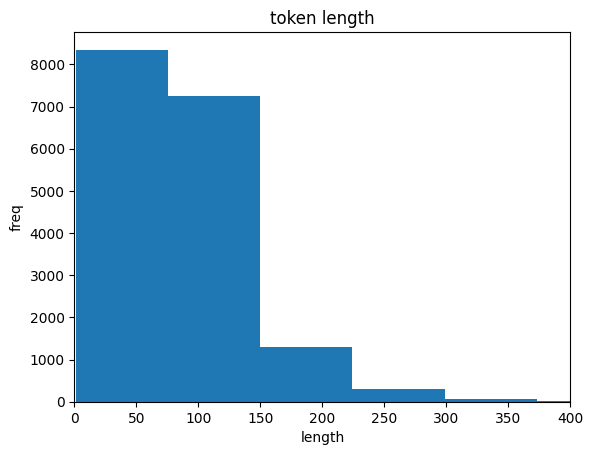

In [160]:
plt.hist(token_length_list)
plt.title('token length')
plt.xlabel('length')
plt.ylabel('freq')
plt.xlim(0, 400)
plt.show()

In [161]:
max_length = 50
front = False

train_pad_token = pad_token_tensor(train_tensor_token, max_length=max_length, cut_front=front, padding_token=0)
valid_pad_token = pad_token_tensor(valid_tensor_token, max_length=max_length, cut_front=front, padding_token=0)
test_pad_token = pad_token_tensor(test_tensor_token, max_length=max_length, cut_front=front, padding_token=0)

train_pad_token[0], train_pad_token.shape

(tensor([ 2,  3,  4,  5,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 15, 19, 20, 12, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 torch.Size([17299, 50]))

In [162]:
train_labels2D = [[label] for label in train_labels]
valid_labels2D = [[label] for label in valid_labels]
test_labels2D = [[label] for label in test_labels]
train_labels2D[:5]

[[0], [1], [0], [1], [1]]

In [163]:
trainDS = TextDataset(train_pad_token, train_labels2D)
validDS = TextDataset(valid_pad_token, valid_labels2D)

In [164]:
# 자연어 분석 모델
class SentenceClassifier(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, n_layers, output_size=1,
                 dropout=0.5, bidirectional=True, model_type="lstm"):
        super().__init__()

        # 임베딩 층
        self.embedding = nn.Embedding(
            num_embeddings = n_vocab,
            embedding_dim = embedding_dim,
            padding_idx=0
        )
        
        # 모델 층 (rnn 또는 lstm)
        if model_type == 'rnn': # rnn일때
            self.model = nn.RNN(
                input_size = embedding_dim,     # 입력 데이터의 차원 (임베딩 차원)
                hidden_size = hidden_dim,       # 은닉 상태 벡터의 차원 (은닉 노드의 수)
                num_layers = n_layers,          # rnn 레이어의 개수
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )

        elif model_type == 'lstm': # lstm일때
            self.model = nn.LSTM(
                input_size = embedding_dim,     # 입력 데이터의 차원 (임베딩 차원)
                hidden_size = hidden_dim,       # 은닉 상태 벡터의 차원 (은닉 노드의 수)
                num_layers = n_layers,          # lstm 레이어의 개수
                bidirectional = bidirectional,
                dropout = dropout,
                batch_first = True
            )

        elif model_type == 'gru':  # GRU 추가
            self.model = nn.GRU(
                input_size=embedding_dim,   
                hidden_size=hidden_dim,     
                num_layers=n_layers,       
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True
            )
        

        # 전결합 층
        if bidirectional == True:
            self.fc = nn.Linear(hidden_dim * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_dim, output_size)
        
        # 드롭아웃 층
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs) # 임베딩 층
        output, _ = self.model(embeddings) # 모델 층
        last_output = output[:, -1, :] # 마지막 타임스탭 출력
        last_output = self.dropout(last_output) # 드롭아웃 층
        logits = self.fc(last_output)
        return logits

In [167]:
batch_size = 8

trainDL = DataLoader(trainDS, batch_size = batch_size)
validDL = DataLoader(validDS, batch_size = batch_size)

n_vocab = len(voca)
hidden_dim = 64
embedding_dim = 128
n_layers = 3
dropout = 0.5

model = SentenceClassifier(n_vocab, hidden_dim, embedding_dim, n_layers, output_size=8,
                           dropout=dropout, bidirectional=True, model_type='rnn')

adam = optim.Adam(model.parameters(), lr=0.001)
rmsprop = optim.RMSprop(model.parameters(), lr=0.001)

EPOCH = 100
MODEL_PATH = '/Users/anhyojun/WorkSpace/LocalData/9번째 프로젝트/임베딩/rnn'

result = training(trainDL, validDL, model, model_type='multiclass', optimizer=adam,
                  epoch=EPOCH, endurance_cnt=10, view_epoch=1, num_classes=8, SAVE_PATH=MODEL_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 0.7172, Test : 0.7038
[Score  : 1/100] Train : 0.5434, Test : 0.5731
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 0.6840, Test : 0.6801
[Score  : 2/100] Train : 0.5688, Test : 0.5739
[Loss : 3/100] Train : 0.6313, Test : 0.6952
[Score  : 3/100] Train : 0.6424, Test : 0.5695
[Loss : 4/100] Train : 0.5333, Test : 0.7393
[Score  : 4/100] Train : 0.7296, Test : 0.5825
[Loss : 5/100] Train : 0.4470, Test : 0.8292
[Score  : 5/100] Train : 0.7843, Test : 0.5885
[Loss : 6/100] Train : 0.3720, Test : 0.9019
[Score  : 6/100] Train : 0.8233, Test : 0.5962


KeyboardInterrupt: 

In [140]:
batch_size = 8

trainDL = DataLoader(trainDS, batch_size = batch_size)
validDL = DataLoader(validDS, batch_size = batch_size)

n_vocab = len(voca)
hidden_dim = 64
embedding_dim = 128
n_layers = 3
dropout = 0.5

model = SentenceClassifier(n_vocab, hidden_dim, embedding_dim, n_layers, output_size=8,
                           dropout=dropout, bidirectional=True, model_type='lstm')

adam = optim.Adam(model.parameters(), lr=0.001)
rmsprop = optim.RMSprop(model.parameters(), lr=0.001)

EPOCH = 100
MODEL_PATH = '/Users/anhyojun/WorkSpace/LocalData/9번째 프로젝트/임베딩/lstm'

result = training(trainDL, validDL, model, model_type='multiclass', optimizer=adam,
                  epoch=EPOCH, endurance_cnt=10, view_epoch=1, num_classes=8, SAVE_PATH=MODEL_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/100] Train : 1.3730, Test : 1.3018
[Score  : 1/100] Train : 0.3305, Test : 0.3473
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/100] Train : 1.2137, Test : 1.2124
[Score  : 2/100] Train : 0.4277, Test : 0.4119
[Loss : 3/100] Train : 1.0299, Test : 1.2572
[Score  : 3/100] Train : 0.5259, Test : 0.4442
[Loss : 4/100] Train : 0.8390, Test : 1.3609
[Score  : 4/100] Train : 0.6408, Test : 0.4423
[Loss : 5/100] Train : 0.6142, Test : 1.6555
[Score  : 5/100] Train : 0.7651, Test : 0.4502
[Loss : 6/100] Train : 0.4308, Test : 1.8664
[Score  : 6/100] Train : 0.8476, Test : 0.4537
[Loss : 7/100] Train : 0.2957, Test : 2.0954
[Score  : 7/100] Train : 0.9004, Test : 0.4555
[Loss : 8/100] Train : 0.2257, Test : 2.3049
[Score  : 8/100] Train : 0.9234, Test : 0.4557
[Loss : 9/100] Train : 0.1789, Test : 2.3015
[Score  : 9/100] Train : 0.9396, Test : 0.4488
[Loss : 10/100] Train : 0.1353, Test : 2.6607
[Score  : 10/100] Train : 0.9543, Test : 0.4533
[Loss : 11/100] Train : 0.1124

In [ ]:
batch_size = 8

trainDL = DataLoader(trainDS, batch_size = batch_size)
validDL = DataLoader(validDS, batch_size = batch_size)

n_vocab = len(voca)
hidden_dim = 64
embedding_dim = 128
n_layers = 3
dropout = 0.5

model = SentenceClassifier(n_vocab, hidden_dim, embedding_dim, n_layers, output_size=8,
                           dropout=dropout, bidirectional=True, model_type='gru')

adam = optim.Adam(model.parameters(), lr=0.001)
rmsprop = optim.RMSprop(model.parameters(), lr=0.001)

EPOCH = 100
MODEL_PATH = '/Users/anhyojun/WorkSpace/LocalData/9번째 프로젝트/임베딩/gru'

result = training(trainDL, validDL, model, model_type='multiclass', optimizer=adam,
                  epoch=EPOCH, endurance_cnt=10, view_epoch=1, num_classes=8, SAVE_PATH=MODEL_PATH)